## American Airlines Stock Price Prediction using LSTM
This project leverages historical American Airlines (AAL) stock price data to develop a predictive model using Long Short-Term Memory (LSTM) neural networks. The model is trained on a windowed dataset, where each sample consists of a sequence of past prices, and is evaluated on its ability to accurately forecast future prices on validation and testing sets. Recursive predictions are also made to demonstrate the model's performance in a real-world scenario. The goal of this project is to explore the potential of LSTM models in stock price prediction and to provide insights into the dynamics of the AAL stock market.

In [58]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [59]:
# Load the AAL stock price data from a CSV file
df = pd.read_csv('AAL.csv')

In [60]:
# Display the first few rows of the data
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-09-27,21.049999,21.400000,19.100000,19.299999,18.194912,961200
1,2005-09-28,19.299999,20.530001,19.200001,20.500000,19.326204,5747900
2,2005-09-29,20.400000,20.580000,20.100000,20.209999,19.052807,1078200
3,2005-09-30,20.260000,21.049999,20.180000,21.010000,19.806997,3123300
4,2005-10-03,20.900000,21.750000,20.900000,21.500000,20.268946,1057900


In [61]:
# Select only the 'Date' and 'Close' columns
df = df[['Date','Close']]
df

,Date,Close
0,2005-09-27,19.299999
1,2005-09-28,20.500000
2,2005-09-29,20.209999
3,2005-09-30,21.010000
4,2005-10-03,21.500000
...,...,...
4147,2022-03-18,16.750000
4148,2022-03-21,16.090000
4149,2022-03-22,16.559999
4150,2022-03-23,16.209999


In [62]:
df['Date']

0       2005-09-27
1       2005-09-28
2       2005-09-29
3       2005-09-30
4       2005-10-03
           ...    
4147    2022-03-18
4148    2022-03-21
4149    2022-03-22
4150    2022-03-23
4151    2022-03-24
Name: Date, Length: 4152, dtype: object

In [63]:
import datetime
# Define a function to convert a string date to a datetime object
def string_to_date(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = string_to_date('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [64]:
df

,Date,Close
0,2005-09-27,19.299999
1,2005-09-28,20.500000
2,2005-09-29,20.209999
3,2005-09-30,21.010000
4,2005-10-03,21.500000
...,...,...
4147,2022-03-18,16.750000
4148,2022-03-21,16.090000
4149,2022-03-22,16.559999
4150,2022-03-23,16.209999


In [65]:
# Apply the string_to_date function to the 'Date' column
df['Date'] = df['Date'].apply(string_to_date)
df['Date']

0      2005-09-27
1      2005-09-28
2      2005-09-29
3      2005-09-30
4      2005-10-03
          ...    
4147   2022-03-18
4148   2022-03-21
4149   2022-03-22
4150   2022-03-23
4151   2022-03-24
Name: Date, Length: 4152, dtype: datetime64[ns]

In [66]:
# Set the 'Date' column as the index of the dataframe
df.index = df.pop('Date')
df

,Close
Date,
2005-09-27,19.299999
2005-09-28,20.500000
2005-09-29,20.209999
2005-09-30,21.010000
2005-10-03,21.500000
...,...
2022-03-18,16.750000
2022-03-21,16.090000
2022-03-22,16.559999


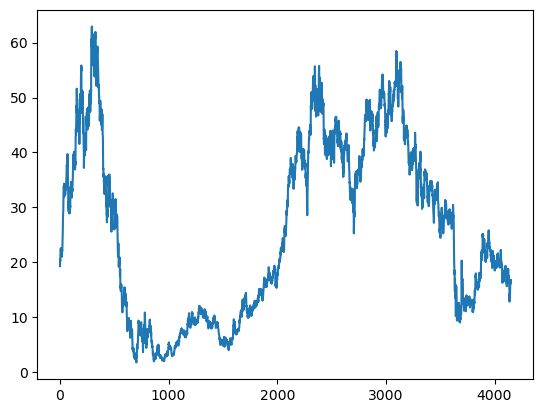

In [46]:
# Plot the stock prices over time
plt.plot(df.index, df['Close'])
plt.show()

In [29]:
# Define a function to create a windowed dataframe for training a model
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  # Convert the input date strings to datetime objects
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  # Initialize variables for the loop
  dates = []
  X, Y = [], []

  last_time = False
  # Loop until we reach the last date  
  while True:
    # Get the last n+1 rows of data up to the target date
    df_subset = dataframe.loc[:target_date].tail(n+1)
    # Check if we have enough data for the window
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return
    # Extract the values and target value from the subset
    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]
    # Append the date, features, and target to the lists
    dates.append(target_date)
    X.append(x)
    Y.append(y)
    # Move to the next date
    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    # Check if we've reached the last date
    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True
  # Create a new dataframe with the windowed data
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Create a windowed dataframe for training
windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2022-03-23',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,23.830000,22.270000,21.809999,22.770000
1,2021-03-26,22.270000,21.809999,22.770000,22.930000
2,2021-03-29,21.809999,22.770000,22.930000,22.910000
3,2021-03-30,22.770000,22.930000,22.910000,24.120001
4,2021-03-31,22.930000,22.910000,24.120001,23.900000
...,...,...,...,...,...
247,2022-03-17,14.250000,15.570000,16.469999,16.549999
248,2022-03-18,15.570000,16.469999,16.549999,16.750000
249,2022-03-21,16.469999,16.549999,16.750000,16.090000
250,2022-03-22,16.549999,16.750000,16.090000,16.559999


In [30]:
# Define a function to convert a windowed dataframe to date, X, and y arrays
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)
# Convert the windowed dataframe to date, X, and y arrays
dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

In [ ]:
# Split the data into training, validation, and testing sets
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

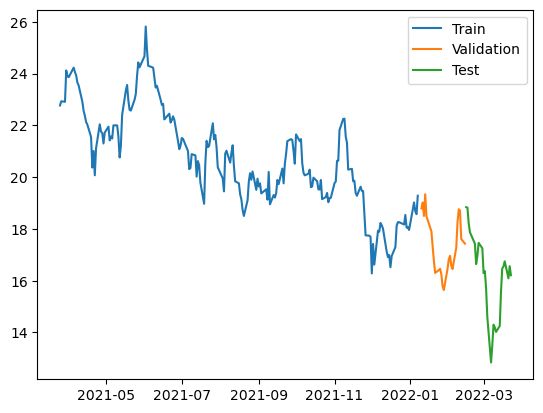

In [31]:
# Plot the training, validation, and testing data
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.legend(['Train', 'Validation', 'Test'])
plt.show()

In [32]:
# Import necessary modules from TensorFlow Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
# Create a Sequential model
model = Sequential([# Input layer with shape (3, 1) - 3 timesteps, 1 feature
                    layers.Input((3, 1)),
                    # LSTM layer with 64 units
                    layers.LSTM(64),
                    # Dense layer with 32 units, ReLU activation
                    layers.Dense(32, activation='relu'),
                    # Dense layer with 32 units, ReLU activation
                    layers.Dense(32, activation='relu'),
                    # Output layer with 1 unit
                    layers.Dense(1)])
# Compile the model with mean squared error loss, Adam optimizer, and mean absolute error metric
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])
# Train the model on the training data with validation data
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 415.2625 - mean_absolute_error: 20.2855 - val_loss: 271.5349 - val_mean_absolute_error: 16.4437
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 389.5604 - mean_absolute_error: 19.6387 - val_loss: 248.7688 - val_mean_absolute_error: 15.7362
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 361.5612 - mean_absolute_error: 18.9179 - val_loss: 215.6252 - val_mean_absolute_error: 14.6449
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 315.7562 - mean_absolute_error: 17.6617 - val_loss: 171.1375 - val_mean_absolute_error: 13.0374
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 259.6339 - mean_absolute_error: 15.9805 - val_loss: 114.6742 - val_mean_absolute_error: 10.6536
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 180.8788 - mean_absolute_error: 13.2889 - val_loss: 50.2109 - val_mean_absolute_error: 7.0009
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 91.4369 - mean_absolute_

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7344 - mean_absolute_error: 1.0625 - val_loss: 3.9484 - val_mean_absolute_error: 1.8490
Epoch 46/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.6489 - mean_absolute_error: 1.0175 - val_loss: 5.7703 - val_mean_absolute_error: 2.2990
Epoch 47/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8043 - mean_absolute_error: 1.1021 - val_loss: 2.9276 - val_mean_absolute_error: 1.5657
Epoch 48/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3098 - mean_absolute_error: 0.9397 - val_loss: 3.4884 - val_mean_absolute_error: 1.7481
Epoch 49/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1905 - mean_absolute_error: 0.8983 - val_loss: 3.0449 - val_mean_absolute_error: 1.6296
Epoch 50/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9372 - mean_absolute_error: 0.8033 - val_loss: 1.4682 - val_mean_absolute_error: 1.0720
Epoch 51/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7300 - mean_absolute_error: 0.6945 - val_loss: 2.3364 - val_mean

Epoch 90/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3146 - mean_absolute_error: 0.4434 - val_loss: 0.4477 - val_mean_absolute_error: 0.5945
Epoch 91/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2939 - mean_absolute_error: 0.4126 - val_loss: 0.3866 - val_mean_absolute_error: 0.5476
Epoch 92/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2967 - mean_absolute_error: 0.4217 - val_loss: 0.4223 - val_mean_absolute_error: 0.5761
Epoch 93/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3245 - mean_absolute_error: 0.4487 - val_loss: 0.3372 - val_mean_absolute_error: 0.5056
Epoch 94/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3226 - mean_absolute_error: 0.4413 - val_loss: 0.3239 - val_mean_absolute_error: 0.4922
Epoch 95/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3175 - mean_absolute_error: 0.4406 - val_loss: 0.4178 - val_mean_absolute_error: 0.5729
Epoch 96/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3174 - mean_absolute_error: 0.4426 - val_loss:

In [ ]:
# Make predictions on the training data using the trained model
train_predictions = model.predict(X_train).flatten()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


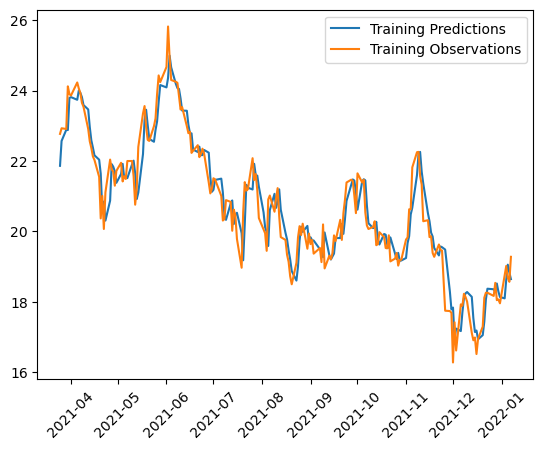

In [41]:
# Create a plot to visualize the training predictions and actual observations
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Make predictions on the validation data using the trained model
val_predictions = model.predict(X_val).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


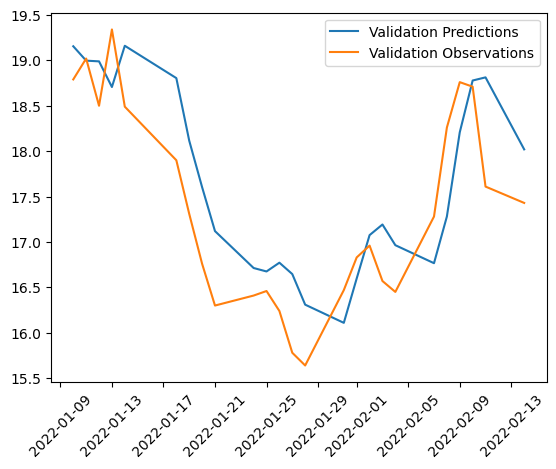

In [40]:
# Create a plot to visualize the validation predictions and actual observations
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Make predictions on the testing data using the trained model
test_predictions = model.predict(X_test).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


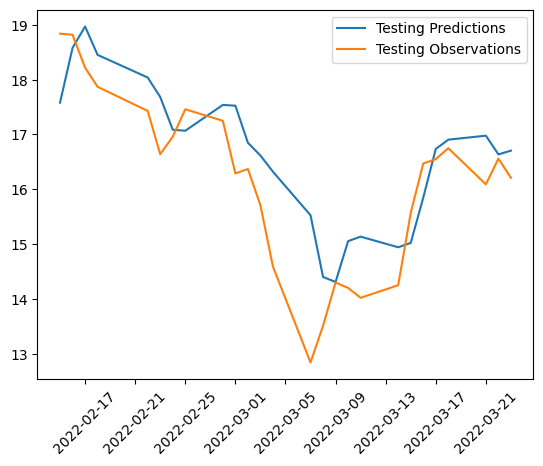

In [39]:
# Create a plot to visualize the testing predictions and actual observations
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])
plt.xticks(rotation=45)
plt.show()

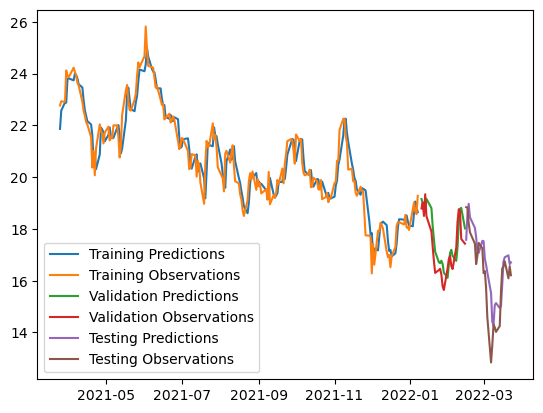

In [36]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [37]:
# Import the deepcopy function from the copy module, which is used to create a deep copy of a list
from copy import deepcopy
# Initialize empty lists to store the recursive predictions and dates
recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])
# Iterate over each target date in the recursive dates list
for target_date in recursive_dates:
  # Create a deep copy of the last window of the training data  
  last_window = deepcopy(X_train[-1])
  # Use the model to make a prediction on the last window  
  next_prediction = model.predict(np.array([last_window])).flatten()
  # Append the prediction to the recursive predictions list  
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

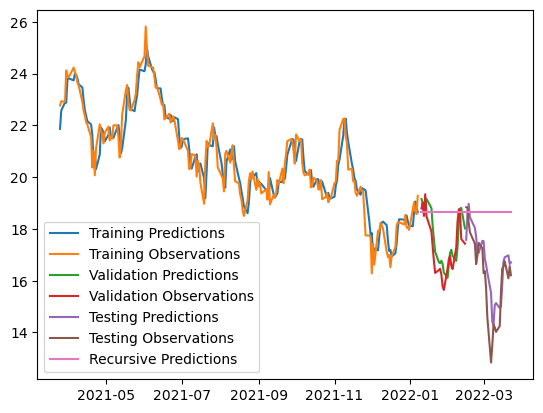

In [38]:
# Plot the model's predictions and actual observations for training, validation, and testing datasets
# and also plot the recursive predictions
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])
plt.show()